In [11]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

In [12]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [13]:
# Create tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [14]:
# Create LLM that can call tools 
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [15]:
sys_msg = SystemMessage(content="Use either tools to perform arithmetic on a set of inputs or just give me answer with your knowledge")

def assistant(state: MessagesState):
   llm_result_messages = llm_with_tools.invoke([sys_msg] + state["messages"])
   return {"messages": llm_result_messages}


In [16]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)
react_graph = builder.compile()


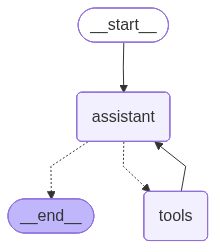

In [7]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [17]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
response = react_graph.invoke({"messages": messages})

In [9]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (0959f2b1-6229-4d18-8a42-98786ffda33c)
 Call ID: 0959f2b1-6229-4d18-8a42-98786ffda33c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (a641b6d1-a3fe-4dde-bbfc-bc98c7be6777)
 Call ID: a641b6d1-a3fe-4dde-bbfc-bc98c7be6777
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (10ac42e2-ff24-40ee-9fcb-5bb1adbcb8d8)
 Call ID: 10ac42e2-ff24-40ee-9fcb-5bb1adbcb8d8
  Args:
    a: 14
    b: 5
====================

In [10]:
messages = [HumanMessage(content="What is the capital of Spain?")]
messages = react_graph.invoke({"messages": messages})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the capital of Spain?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The capital of Spain is Madrid.', 'extras': {'signature': 'CqICAXLI2nymT1lpIB9T/ivcpVk3zjIET3qGEHfB+uLRiuiUujQcfIua+RPZSA0ENLwce7zEbYT6KqsGXqOOrtX/vPf6ZMJwin7lSGbYVtLX4me6tPIXu4lo2N06S10EhLzY9wMlng+Qs2fWV4+vajQw5B8DCyuGmELqXoKPxf4d3bozQGHykoRDGzgJhJI2Gh0bDyM2tb6OcRh9F1UU0djLvQ9D1Y4mqwhburIvdWXzwnuvQAyZVIRMH7z1GaI5GKVAELB7sDT0yfO/0c1tDn0qBmnILRnTRv+ycFCeZVL+SYLX+rAJYrrg0CjxE2Wd4roavkNVdqH4SUxlrE9qLowP2i7yMYog8klZM2JMT1gESCgnZ8MkIZs4lk3n5/4TINvRfVk='}}]
